# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [6]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
# To start off let's do a basic data summary.
n_train = X_train.shape[0]

n_test = X_test.shape[0]

# assume [height, width, channels]
height = X_train.shape[1]
width = X_train.shape[2]
channels = X_train.shape[3]

image_shape = [height, width, channels]

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Preprocess the data here.
def weighted_average(pixel):
    return [0.3 * pixel[0] + 0.6 * pixel[1] + 0.1 * pixel[2]]

def greyed_image(image):
    grey = np.zeros((height, width, 1))
    for row in range(height):
        for col in range(width):
            grey[row][col] = weighted_average(image[row][col])
    return grey

In [33]:
# convert RGB (3 channels) to greyscale (1 channel)
train_images = []
for image in tqdm(X_train):
    grey_image = greyed_image(image)
    train_images.append(grey_image)
    
test_images = []
for image in tqdm(X_test):
    grey_image = greyed_image(image)
    test_images.append(grey_image)

100%|██████████| 12630/12630 [01:53<00:00, 111.14it/s]


In [106]:
# reformat labels
train_labels = np.zeros((n_train, n_classes))
for idx, num in enumerate(y_train):
    train_labels[idx][num] = 1.0
    
test_labels = np.zeros((n_test, n_classes))
for idx, num in enumerate(y_test):
    test_labels[idx][num] = 1.0

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

For the features, I converted RGB images to greyscale images by taking a weighted average of three colour channels.

For the labels, I created binary arrays where for each array is of zeros with one exception (for the index of the sign from the corresponding image, the value is one).

In [107]:
# shuffle features and labels
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I shuffled training data to ensure the efficiency of training.

In [108]:
import tensorflow as tf

# referenced https://github.com/aymericdamien/
# TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py

# hyperparameters
learning_rate = 0.001
epochs = 6
batch_size = 64
display_step = 100

conv_size = 5
conv_filter_1 =  16
conv_filter_2 =  36
fully_in = 8 * 8 * conv_filter_2
fully_size = 128
std = 0.05
channels = 1

# input
x = tf.placeholder(tf.float32, [None, height, width, channels])
y = tf.placeholder(tf.float32, [None, n_classes])

weights = {
    'conv1': tf.Variable(tf.truncated_normal([conv_size, conv_size, channels, conv_filter_1], stddev=std)),
    'conv2': tf.Variable(tf.truncated_normal([conv_size, conv_size, conv_filter_1, conv_filter_2], stddev=std)),
    'full': tf.Variable(tf.truncated_normal([fully_in, fully_size], stddev=std)),
    'out': tf.Variable(tf.truncated_normal([fully_size, n_classes], stddev=std))
}

biases = {
    'conv1': tf.Variable(tf.truncated_normal([conv_filter_1])),
    'conv2': tf.Variable(tf.truncated_normal([conv_filter_2])),
    'full': tf.Variable(tf.truncated_normal([fully_size])),
    'out': tf.Variable(tf.truncated_normal([n_classes]))
}

# conv layer, with bias and activation
def conv(x, W, b):
    layer = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = tf.nn.bias_add(layer, b)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.nn.relu(layer)
    return layer

def model(x, weights, biases):
    # conv network
    conv1 = conv(x, weights['conv1'], biases['conv1'])
    conv2 = conv(conv1, weights['conv2'], biases['conv2'])
    # flatten conv
    flat = tf.reshape(conv2, [-1, weights['full'].get_shape().as_list()[0]])
    # fully connected
    fc = tf.add(tf.matmul(flat, weights['full']), biases['full'])
    fc = tf.nn.relu(fc)
    # output
    output = tf.add(tf.matmul(fc, weights['out']), biases['out'])
    return output

pred = model(x, weights, biases)

# loss and optimization
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# evaluate
prediction = tf.equal(tf.argmax(tf.nn.softmax(pred), 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I used two layers of connvolutional neural network, followed by one fully connected layer. Then process with the output wright and bias.

In [109]:
# initialize
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

for i in tqdm(range(epochs)):
    total_batches = int(n_train / batch_size)
    for step in range(total_batches):
        start = step * batch_size
        end = (step + 1) * batch_size
        batch_x = train_images[start: end]
        batch_y = train_labels[start: end]
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        if step % display_step == 0:
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            print("Batch " + str(step*batch_size) + ", Accuracy= " + "{:>6.1%}".format(acc))
print("Training Finished!")

print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_images, y: test_labels}))

  0%|          | 0/6 [00:00<?, ?it/s]

Batch 0, Accuracy=   3.1%
Batch 6400, Accuracy=  54.7%
Batch 12800, Accuracy=  79.7%
Batch 19200, Accuracy=  89.1%
Batch 25600, Accuracy=  90.6%
Batch 32000, Accuracy=  98.4%
Batch 38400, Accuracy=  98.4%


 17%|█▋        | 1/6 [02:09<10:46, 129.40s/it]

Batch 0, Accuracy= 100.0%
Batch 6400, Accuracy= 100.0%
Batch 12800, Accuracy=  98.4%
Batch 19200, Accuracy=  98.4%
Batch 25600, Accuracy=  98.4%
Batch 32000, Accuracy= 100.0%
Batch 38400, Accuracy=  98.4%


 33%|███▎      | 2/6 [03:46<07:58, 119.64s/it]

Batch 0, Accuracy=  98.4%
Batch 6400, Accuracy= 100.0%
Batch 12800, Accuracy=  98.4%
Batch 19200, Accuracy= 100.0%
Batch 25600, Accuracy=  98.4%
Batch 32000, Accuracy= 100.0%
Batch 38400, Accuracy= 100.0%


 50%|█████     | 3/6 [05:26<05:41, 113.82s/it]

Batch 0, Accuracy= 100.0%
Batch 6400, Accuracy= 100.0%
Batch 12800, Accuracy=  98.4%
Batch 19200, Accuracy= 100.0%
Batch 25600, Accuracy= 100.0%
Batch 32000, Accuracy= 100.0%
Batch 38400, Accuracy=  98.4%


 67%|██████▋   | 4/6 [06:56<03:33, 106.73s/it]

Batch 0, Accuracy= 100.0%
Batch 6400, Accuracy= 100.0%
Batch 12800, Accuracy=  98.4%
Batch 19200, Accuracy=  96.9%
Batch 25600, Accuracy= 100.0%
Batch 32000, Accuracy= 100.0%
Batch 38400, Accuracy= 100.0%


 83%|████████▎ | 5/6 [08:41<01:46, 106.13s/it]

Batch 0, Accuracy= 100.0%
Batch 6400, Accuracy= 100.0%
Batch 12800, Accuracy= 100.0%
Batch 19200, Accuracy= 100.0%
Batch 25600, Accuracy= 100.0%
Batch 32000, Accuracy= 100.0%
Batch 38400, Accuracy=  98.4%


100%|██████████| 6/6 [10:22<00:00, 104.47s/it]


Training Finished!
Testing Accuracy: 0.913302


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used AdamOptimizer as my optimizer. There are 6 epochs, and the batch size of each epoch is 128. I chose a conservative learning rate of 0.001.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

First I tried using a tradiotnal deep neural network, but kept getting accuracy of close to 5%. I thought the low accuracy was due to wrong 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

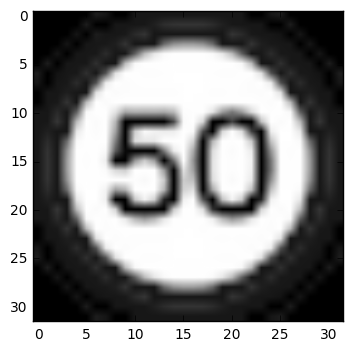

In [110]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

my_images = []
for i in range(8):
    image_path = './p' + str(i) + '.jpg'
    image = mpimg.imread(image_path)
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    my_images.append(grey_image)
    
plt.imshow(my_images[0], cmap='gray')
plt.show()

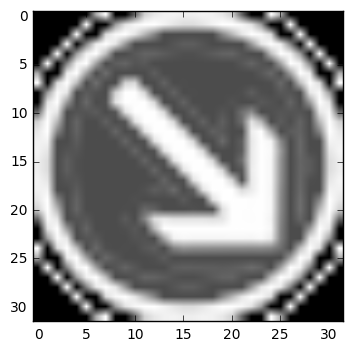

In [111]:
plt.imshow(my_images[7], cmap='gray')
plt.show()

In [121]:
my_test_images = []
for image in my_images:
    my_test_images.append(np.reshape(grey_image, [height, width, 1]))

In [122]:
my_test_labels = np.zeros((8, n_classes))

my_test_labels[0][2] = 1. # 50
my_test_labels[1][3] = 1. # 60
my_test_labels[2][7] = 1. # 100
my_test_labels[3][8] = 1. # 120
my_test_labels[4][14] = 1. # stop
my_test_labels[5][15] = 1. # no vehicle
my_test_labels[6][35] = 1. # ahead only
my_test_labels[7][38] = 1. # keep right

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

For the provided iamges, the traffic signs are centred in the middle, while my traffic signs take over almost entirety of the images.

In [159]:
print("My Testing Accuracy:", sess.run(accuracy, feed_dict={x: my_test_images, y: my_test_labels}))

My Testing Accuracy: 0.125


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

No. The accuracy is merely 0.125, suggesting only 1/8 images has been correctly identified.

In [155]:
p = sess.run(tf.nn.softmax(pred), feed_dict={x: my_test_images, y: my_test_labels})

for p_i in p:
    values, indices = sess.run(tf.nn.top_k(r, k=5))
    print(values, indices)

[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]
[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]
[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]
[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]
[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]
[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]
[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]
[  1.00000000e+00   4.07366798e-17   9.61953812e-18   1.94667134e-18
   7.07876634e-23] [38 34 31 23 22]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The result is quite shocking as all of them has sign 38 (keep right) as the top 1 choice (almost 100%). Also none of of the otehr signs are included in the top 5.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.